## Unsupervised Anomaly Detection in Multivariate Time Series

### Dataset 1 - NASA Bearing Test
- Data are downsampled versions of Set No. 1 (NASA Bearing Test datasets)
- Data obtained online from https://www.kaggle.com/vinayak123tyagi/bearing-dataset.
- Original raw data was 1-sec vibration signal snapshots with 20 kHz sampling rate.
- Raw data has 20,480 rows in each of 2,156 files & 8 feature channels (2x for each of 4x bearings).
- Feature channels are accelerometer data.
- Downsample dataset has 21,560 rows (downsampled to ~0.1s timestep).
- The test ends with inner race defect (bearing 3) & roller element defect (bearing 4).
- Goal is identify the bearing degradation prior to failure.

**Models Evaluated**: 
* MODEL 1. PCA with Mahalonobis Distance
* MODEL 2. K-means Clustering with Euclidean Distance
* MODEL 3. One-class Support Vector Machine (SVM)
* MODEL 4. Isolation Forest
* MODEL 5. LSTM Autoencoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import PdM_functions as pdm # custom functions created for this project that are used in several notebooks
import random as random
import seaborn as sns
sns.set_style('ticks')

### Data Understanding

#### Load Data

In [2]:
"""
Note:
=====
While all NASA data sets are referenced below, this study focuses on 
Test #1 which has 9 fields (timestamp + 8x sensor channels)
21,560 observations in the downsampled dataset (downsampled to ~0.1s timestep)

Test #1 outcome:
================
At the end of the test-to-failure experiment, inner race defect occurred in 
bearing 3 and roller element defect in bearing 4.
"""

# Create a dataframe of file options for easy reference
# We will select a dataset from this dataframe for the analysis/experiments
dataset_options = pd.DataFrame({
    'test':[1, 1, 1, 2, 2, 2, 3, 3, 3],
    'fp':[
        'NASA prepared data/test1_combined_ds.csv',            #0 
        'NASA prepared data/test1_abs_combined_ds.csv',        #1
        'NASA prepared data/merged_dataset_BearingTest_1.csv', #2
        'NASA prepared data/test2_combined_ds.csv',            #3
        'NASA prepared data/test2_abs_combined_ds.csv',        #4
        'NASA prepared data/merged_dataset_BearingTest_2.csv', #5
        'NASA prepared data/test3_combined_ds.csv',            #6
        'NASA prepared data/test3_abs_combined_ds.csv',        #7       
        'NASA prepared data/Reduced/merged_dataset_BearingTest_3.csv' #8
    ],
   ' chans':[
       ['B1_c1', 'B1_c2', 'B2_c3', 'B2_c4', 'B3_c5', 'B3_c6', 'B4_c7', 'B4_c8'],
       ['B1_c1', 'B1_c2', 'B2_c3', 'B2_c4', 'B3_c5', 'B3_c6', 'B4_c7', 'B4_c8'],
       ['B1_c1', 'B1_c2', 'B2_c3', 'B2_c4', 'B3_c5', 'B3_c6', 'B4_c7', 'B4_c8'],
       ['B1_c1', 'B2_c2', 'B3_c3', 'B4_c4'],
       ['B1_c1', 'B2_c2', 'B3_c3', 'B4_c4'],
       ['B1_c1', 'B2_c2', 'B3_c3', 'B4_c4'],
       ['B1_c1', 'B2_c2', 'B3_c3', 'B4_c4'],
       ['B1_c1', 'B2_c2', 'B3_c3', 'B4_c4'],
       ['B1_c1', 'B2_c2', 'B3_c3', 'B4_c4']       
   ]    
})
print('Available files as follows:')
print('===========================')
print(dataset_options.iloc[:, [0, 1]])

Available files as follows:
   test                                                 fp
0     1           NASA prepared data/test1_combined_ds.csv
1     1       NASA prepared data/test1_abs_combined_ds.csv
2     1  NASA prepared data/merged_dataset_BearingTest_...
3     2           NASA prepared data/test2_combined_ds.csv
4     2       NASA prepared data/test2_abs_combined_ds.csv
5     2  NASA prepared data/merged_dataset_BearingTest_...
6     3           NASA prepared data/test3_combined_ds.csv
7     3       NASA prepared data/test3_abs_combined_ds.csv
8     3  NASA prepared data/Reduced/merged_dataset_Bear...


In [3]:
# Select a dataset to analyse by selecting the appropriate index from above
selected_dataset = 0

In [4]:
# Load the data & grab a list of the channel names/refs
selected_fp = dataset_options['fp'][selected_dataset]
df_set = pd.read_csv(selected_fp, sep = ",")
chans = dataset_options.iloc[:, 2][selected_dataset]

#### Data Quality Report

In [5]:
# Rename the columns as per channel definition from NASA test document
df_set = df_set.rename(columns = {'Unnamed: 0' : 'timestamp'})   

In [6]:
df_set.index = df_set['timestamp']

In [7]:
df_set.drop('timestamp', axis = 1, inplace = True)

In [8]:
df_set.describe()

,B1_c1,B1_c2,B2_c3,B2_c4,B3_c5,B3_c6,B4_c7,B5_c8
count,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000
mean,-0.116648,-0.116262,-0.116260,-0.115546,-0.112209,-0.113254,-0.113527,-0.113032
std,0.097380,0.088524,0.094746,0.078626,0.118037,0.122855,0.096138,0.099437
min,-0.652000,-0.725000,-0.684000,-0.552000,-1.541000,-1.096000,-1.050000,-1.062000
25%,-0.181000,-0.173000,-0.181000,-0.166000,-0.186000,-0.188000,-0.166000,-0.168000
50%,-0.117000,-0.115000,-0.115000,-0.115000,-0.112000,-0.112000,-0.112000,-0.112000
75%,-0.054000,-0.059000,-0.051000,-0.063000,-0.039000,-0.037000,-0.061000,-0.059000
max,0.476000,0.576000,0.376000,0.330000,1.484000,1.875000,1.223000,0.776000


In [9]:
# Print a data quality report for the numeric data
pdm.generate_dq_num(df_set, df_set.columns)

,Data Type,Missing Values,Unique Values,Min Value,Mean Value,Median Value,Max Value
B1_c1,float64,0,317,-0.652,-0.116648,-0.117,0.476
B1_c2,float64,0,295,-0.725,-0.116262,-0.115,0.576
B2_c3,float64,0,287,-0.684,-0.116260,-0.115,0.376
B2_c4,float64,0,247,-0.552,-0.115546,-0.115,0.330
B3_c5,float64,0,384,-1.541,-0.112209,-0.112,1.484
B3_c6,float64,0,394,-1.096,-0.113254,-0.112,1.875
B4_c7,float64,0,382,-1.050,-0.113527,-0.112,1.223
B5_c8,float64,0,376,-1.062,-0.113032,-0.112,0.776


No missing data.  Mean and medians appears to be fairly consistent between channels.  Max values for Bearings 3 and 4 are notably higher than the other bearings.  This is in line with what was expected as the test failed with defects in Bearings 3 & 4.

#### Plot Data

In [10]:
estimated_healthy_end_date = np.where(df_set.index == '2003.11.15.05.18.47.023950') # by inspection
estimated_healthy_end_ind = estimated_healthy_end_date[0][0]
estimated_degrading_start_date = np.where(df_set.index == '2003.11.20.15.19.03.568850') # by inspection
estimated_degrading_startend_ind = estimated_degrading_start_date[0][0]

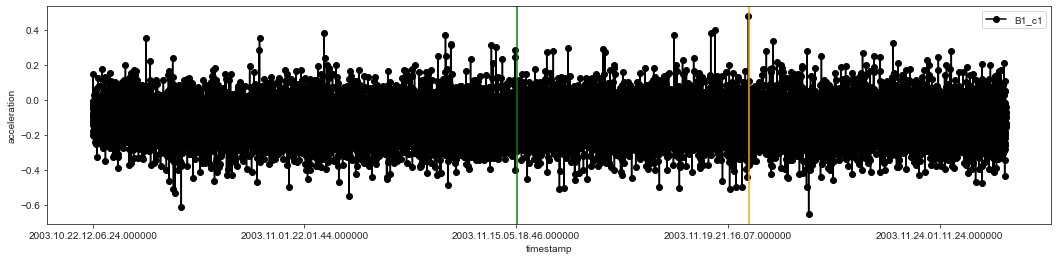

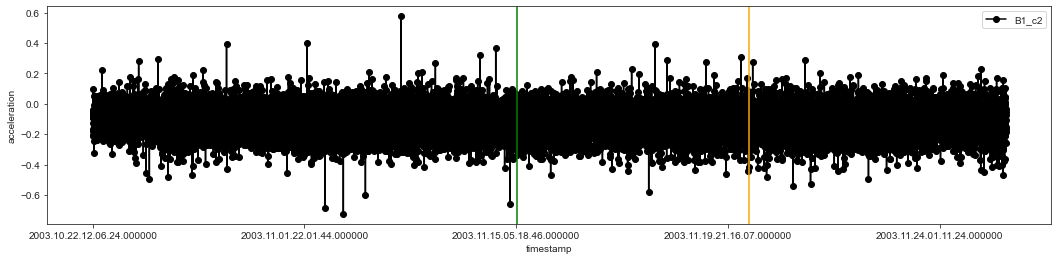

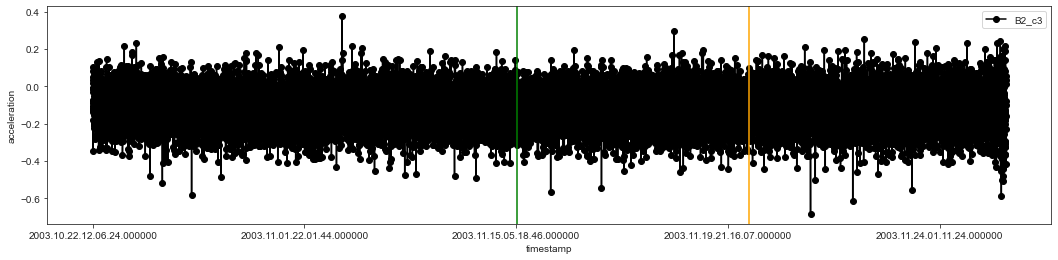

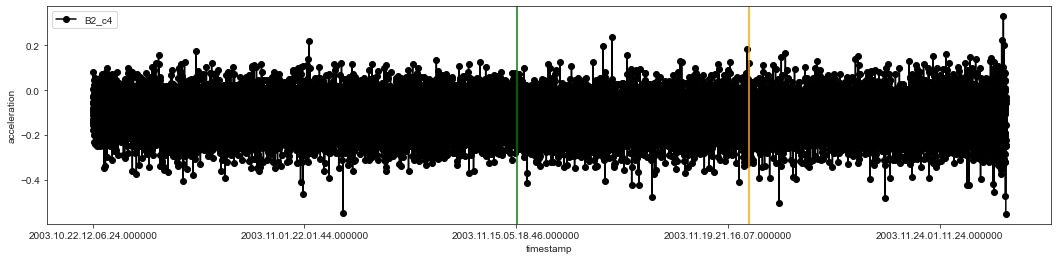

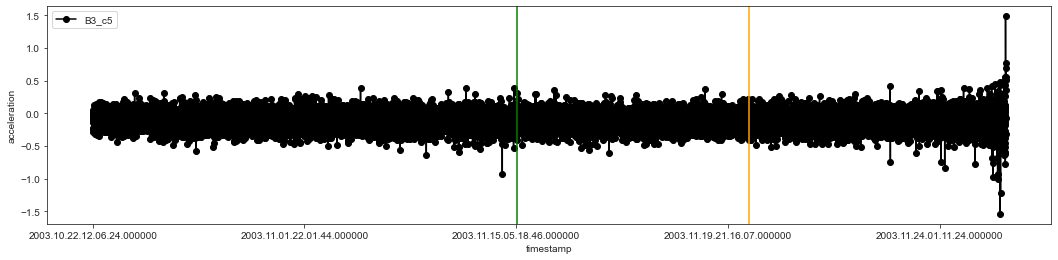

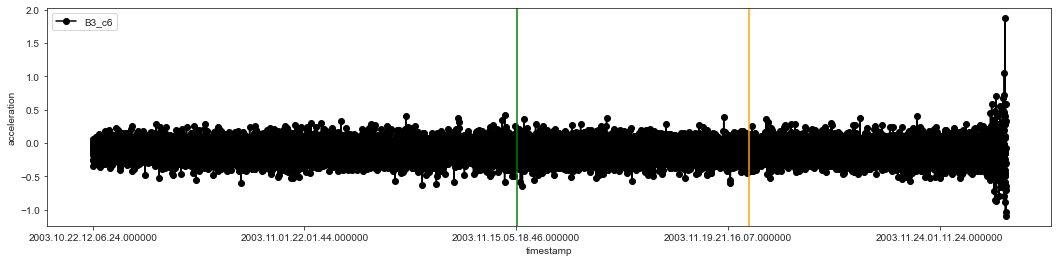

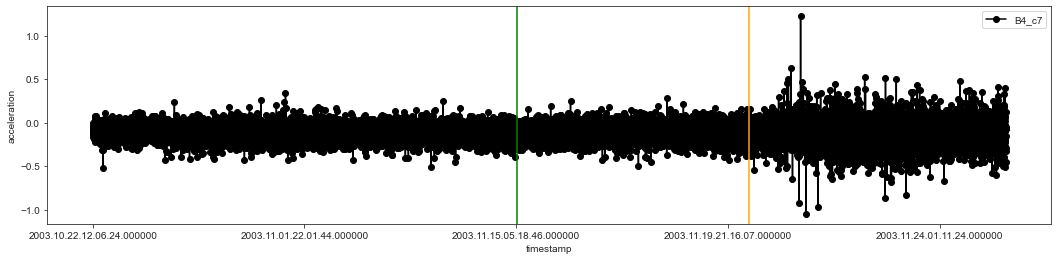

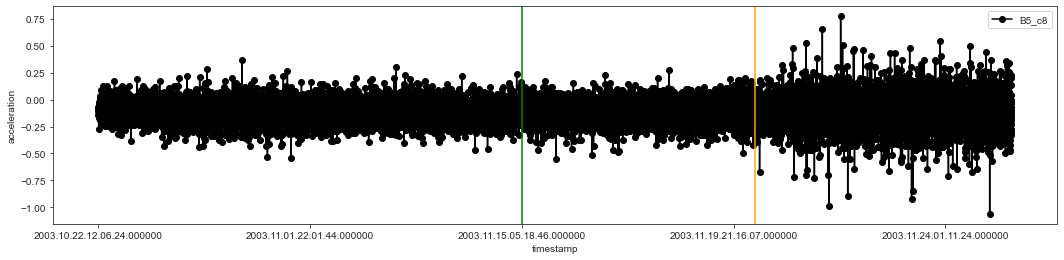

In [11]:
# Plot the downsampled signal
cols = df_set.columns
for chan in cols:
    df_set[[chan]].plot(figsize = (18, 4), color = 'black', marker = 'o')
    plt.axvline(x=estimated_healthy_end_ind , color='green')    
    plt.axvline(x=estimated_degrading_startend_ind , color='orange')  
    plt.ylabel("acceleration")

Notable increases in amplitude in Bearing 3, 4 and 5 towards the end of the test.  Bearing 4 and 5 also seem to display and increase in amplitude in the last 3rd of the test.  This may be an indicator of some degradation starting to occur before the functional failure.

#### Data Distributions

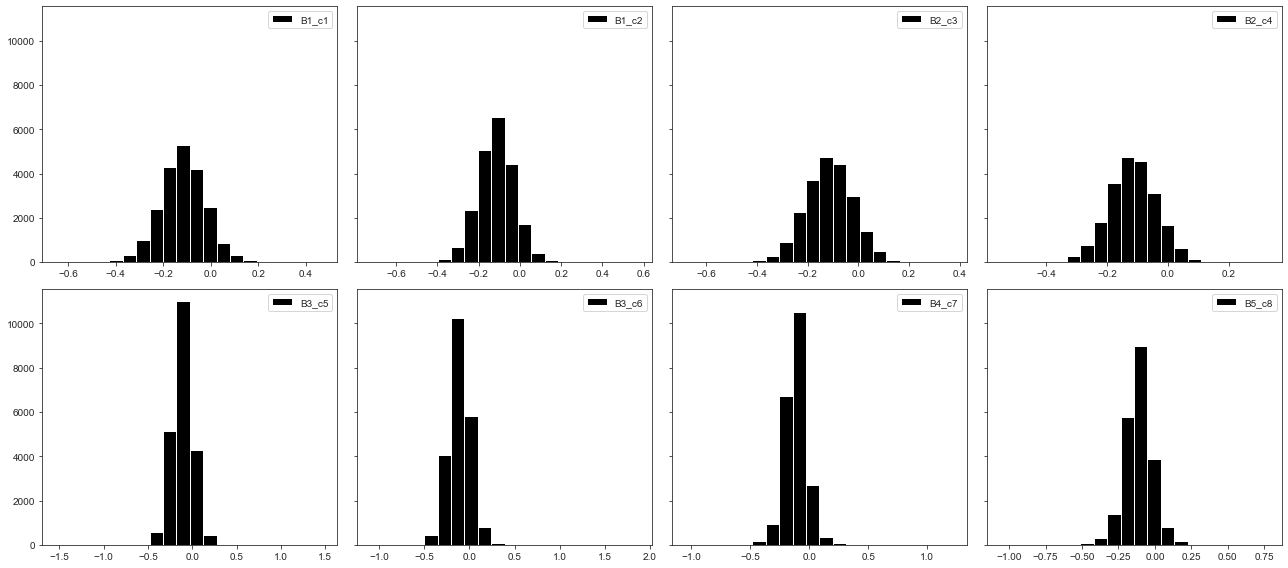

In [12]:
n_bins = 20
fig, axs = plt.subplots(2, 4, sharey=True, tight_layout=True, figsize = (18, 8))
axs = axs.ravel()
for p, ref in enumerate(df_set.columns):
    axs[p].hist(df_set[ref].values, bins=n_bins, label = ref, color = 'black')
    axs[p].legend(loc = 'upper right')

Reasonable distributions in general.  Data for the bearings 1 and 2 channels display a normal distribution.  Other channels are also have a normal distribution but have less variation.  Additional distribution visualisation is provided in the below pair plots.     

#### Scatter Plot Matrix

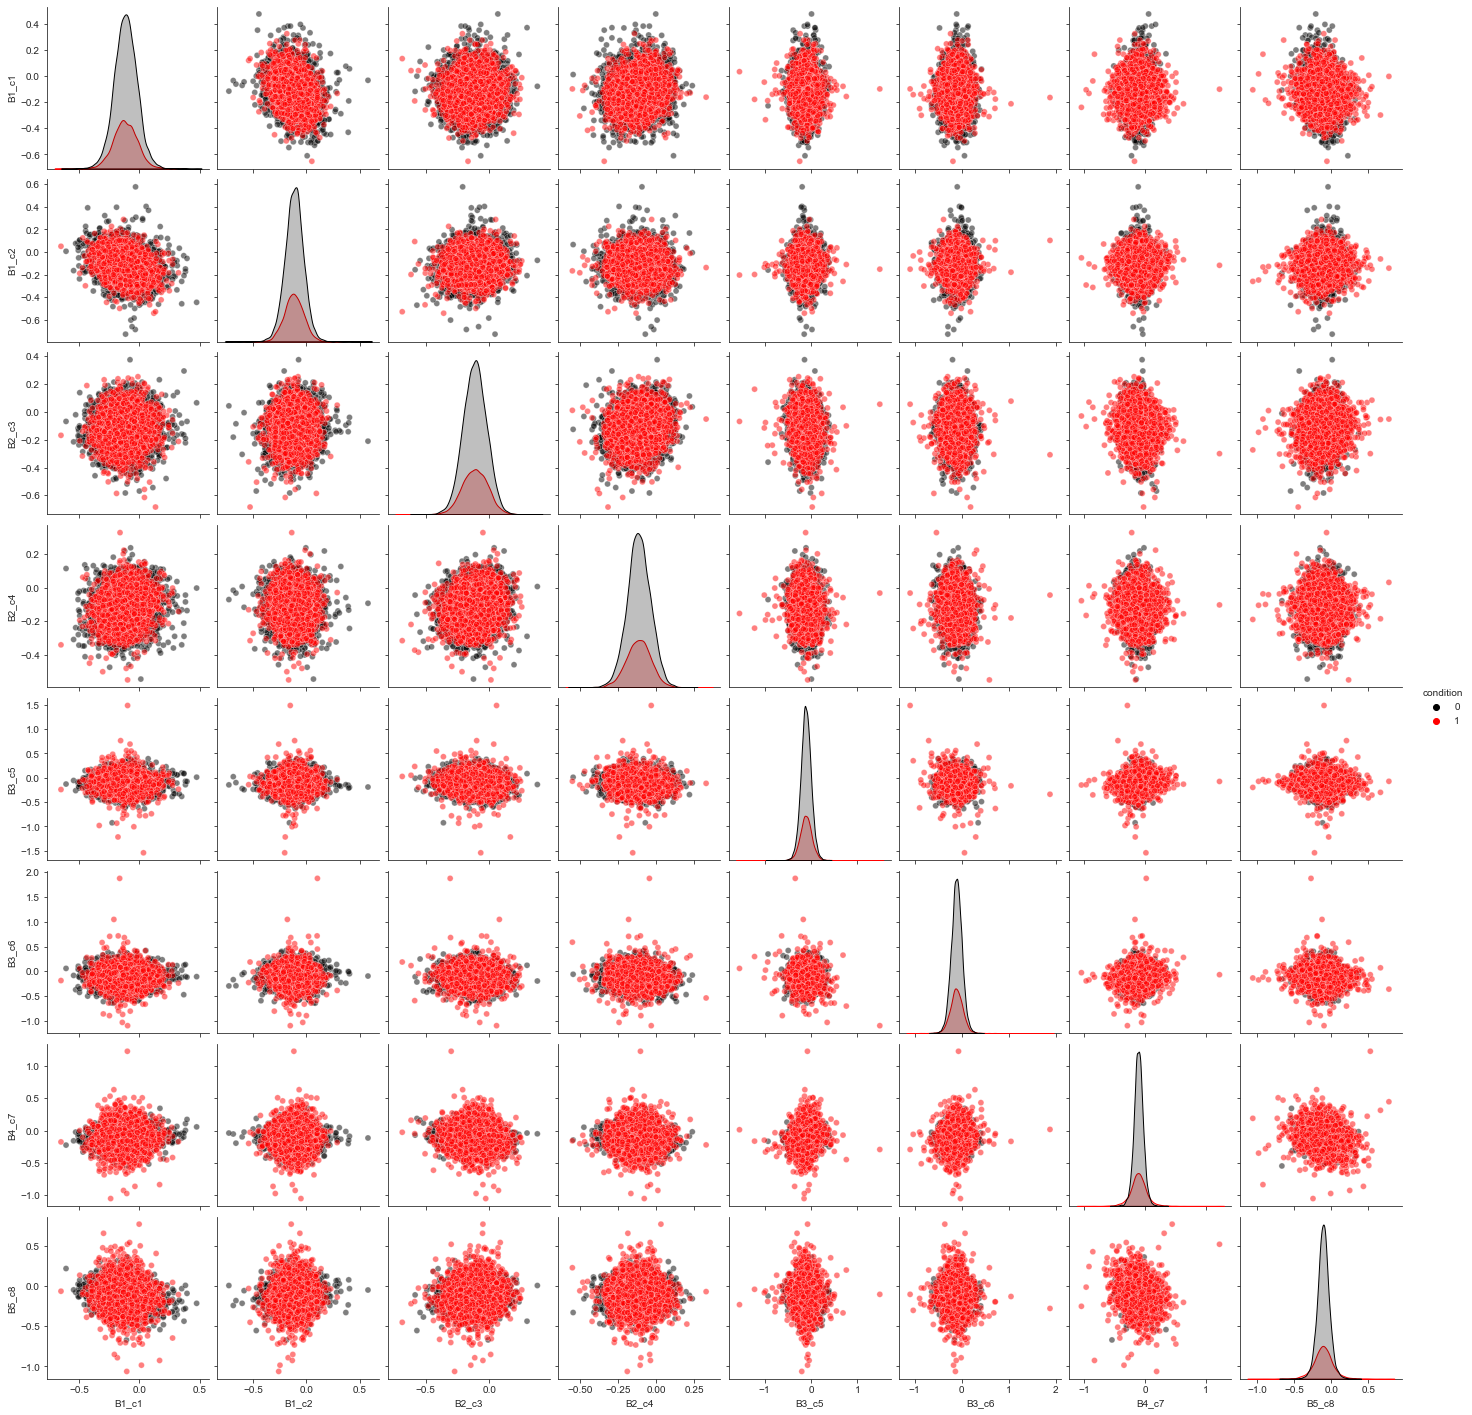

In [93]:
df_class = df_set.copy(deep=True)
df_class['condition'] = (df_set.index > '2003.11.21.00.00.00.000000').astype('int')
#sns.pairplot(df_class, hue='condition', palette={0:'black', 1:'red'}, plot_kws={'alpha': 0.5}) 

The red dots are data points that were recorded in the last (approximate) third of the test.  We can see that the points spread out more for Bearings 3, 4 and 5 in later stages of the test.

In [14]:
# Some inspection on timestamps to help with cut definitions (see later cells)
#df_set['B5_c8'].iloc[0:1500]
df_set['B5_c8'].iloc[1500:15500]

timestamp
2003.10.23.09.24.13.000000   -0.154
2003.10.23.09.24.13.113750   -0.254
2003.10.23.09.24.13.227550   -0.146
2003.10.23.09.24.13.341300   -0.071
2003.10.23.09.24.13.455100   -0.127
                              ...  
2003.11.20.15.19.03.568850   -0.154
2003.11.20.15.19.03.682650   -0.181
2003.11.20.15.19.03.796400   -0.095
2003.11.20.15.19.03.910200   -0.085
2003.11.20.15.19.04.023950    0.066
Name: B5_c8, Length: 14000, dtype: float64

### Data Preparation

In [15]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure

In [16]:
# Scale the data (min = 0, max = 1 for all columns)
scaler = preprocessing.MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_set), columns = df_set.columns, index = df_set.index)
df_scaled.describe()

,B1_c1,B1_c2,B2_c3,B2_c4,B3_c5,B3_c6,B4_c7,B5_c8
count,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000
mean,0.474603,0.467900,0.535604,0.494846,0.472328,0.330780,0.411999,0.516305
std,0.086330,0.068043,0.089383,0.089145,0.039021,0.041351,0.042296,0.054101
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.417553,0.424289,0.474528,0.437642,0.447934,0.305621,0.388913,0.486398
50%,0.474291,0.468870,0.536792,0.495465,0.472397,0.331202,0.412670,0.516866
75%,0.530142,0.511914,0.597170,0.554422,0.496529,0.356446,0.435108,0.545702
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
# Alternative is to standardize the data 
#scaler = preprocessing.StandardScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(df_set), columns = df_set.columns, index = df_set.index)
#df_scaled.describe()

In [18]:
df_scaled.index[0:980]

Index(['2003.10.22.12.06.24.000000', '2003.10.22.12.06.24.113750',
       '2003.10.22.12.06.24.227550', '2003.10.22.12.06.24.341300',
       '2003.10.22.12.06.24.455100', '2003.10.22.12.06.24.568850',
       '2003.10.22.12.06.24.682650', '2003.10.22.12.06.24.796400',
       '2003.10.22.12.06.24.910200', '2003.10.22.12.06.25.023950',
       ...
       '2003.10.23.00.34.13.000000', '2003.10.23.00.34.13.113750',
       '2003.10.23.00.34.13.227550', '2003.10.23.00.34.13.341300',
       '2003.10.23.00.34.13.455100', '2003.10.23.00.34.13.568850',
       '2003.10.23.00.34.13.682650', '2003.10.23.00.34.13.796400',
       '2003.10.23.00.34.13.910200', '2003.10.23.00.34.14.023950'],
      dtype='object', name='timestamp', length=980)

Let's split the dataset into separate train and test sets.  The goal is to select the training set to cover the period of the test where the bearings were in good condition / not degraded, i.e., our 'normal' operating conditions.

In [19]:
data_cuts = pd.DataFrame({
    'cut_ref': [
        't1_1', #1
        't1_2', #2 
        't2_1', #3
        't2_2', #4
        't2_3', #5
        't3_1'  #6
    ],
    'cut_times': [
        ['2003.11.15.05.18.46.000000', '2003.11.15.05.18.47.000000'],          #1
        ['2003-10-29 14:39:46', '2003-11-15 05:18:46', '2003-11-19 21:06:07'], #2 
        ['2004-02-16 16:32:39', '2004-02-16 16:32:39'],                        #3
        ['2004.02.15.05.12.39.000000', '2004.02.15.05.12.39.000000'],          #4
        ['2004.02.14.05.12.39.000000', '2004.02.14.05.12.39.000000'],          #5
        ['2004.03.25.16.51.57.000000', '2004.03.25.16.51.57.000000'],          #6
    ]
})

In [20]:
# Review or populate above & select a cut to analyse/model
selected_cut = 't1_1'

ind = np.where(data_cuts['cut_ref'] == selected_cut)
t_cuts = data_cuts.iloc[np.min(ind), 1]
print('selected cuts: ', t_cuts)

selected cuts:  ['2003.11.15.05.18.46.000000', '2003.11.15.05.18.47.000000']


In [21]:
if len(t_cuts) == 3:
    df_train = df_scaled[t_cuts[0]:t_cuts[1]]
else:
    df_train = df_scaled[:t_cuts[0]]

df_test = df_scaled[t_cuts[1]:]

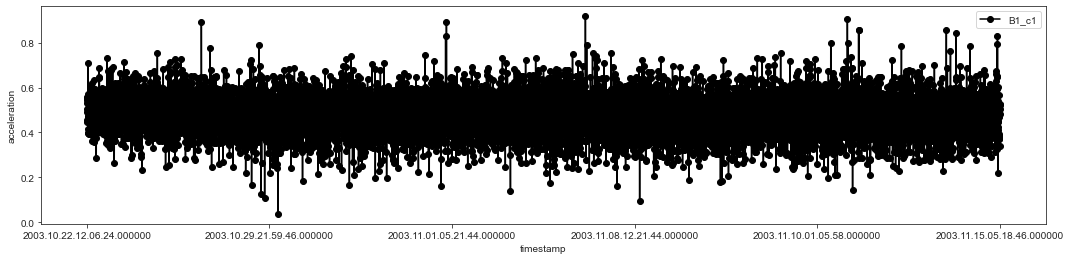

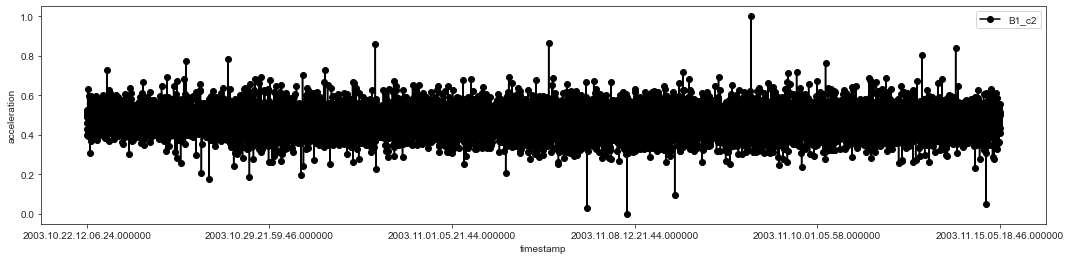

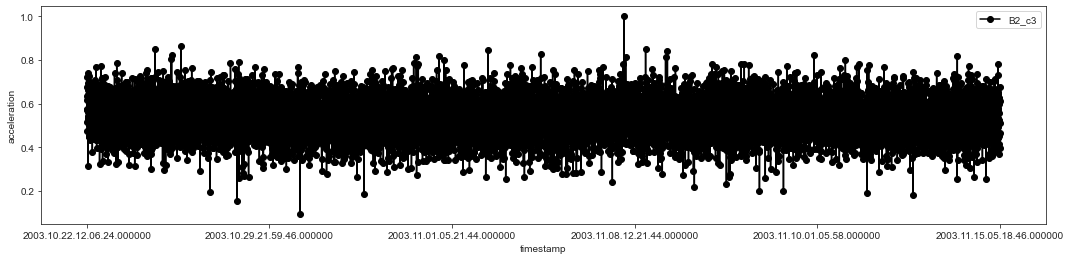

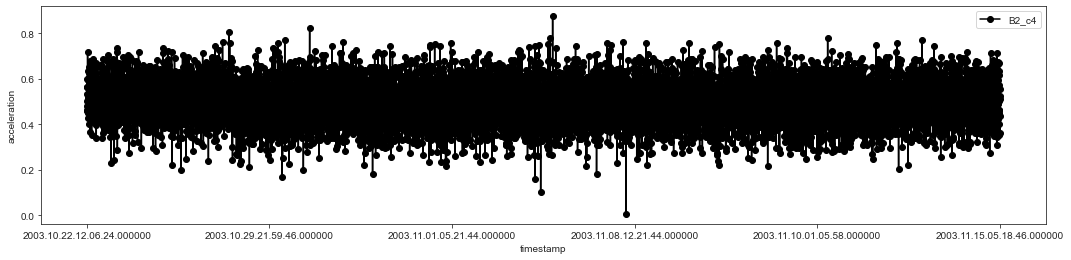

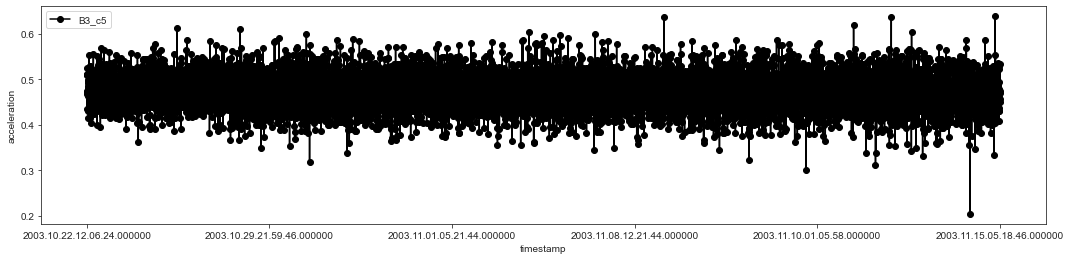

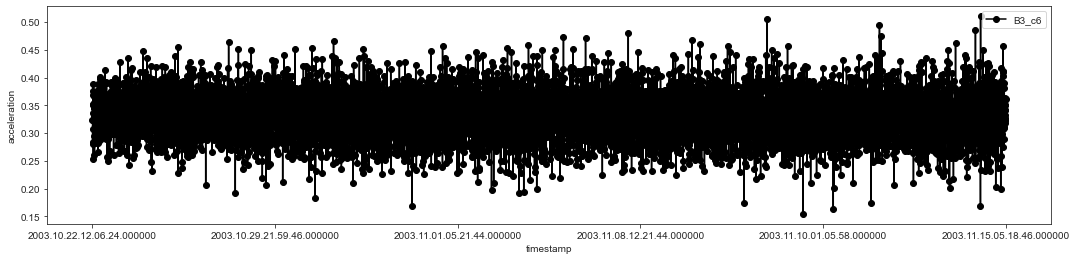

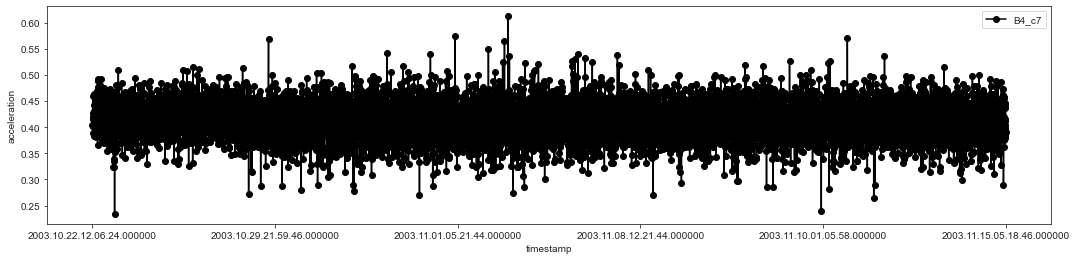

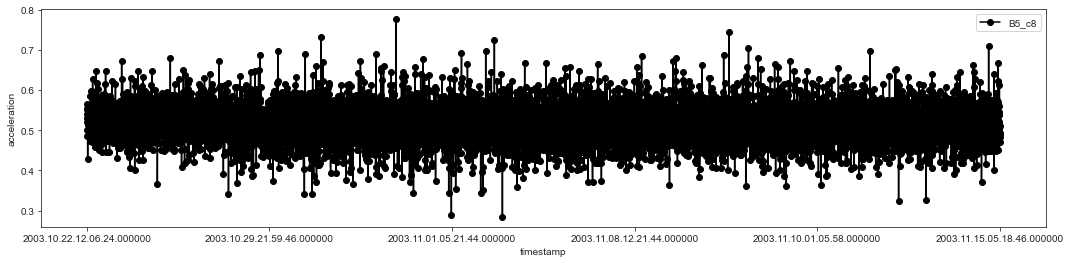

In [22]:
# Plot the downsampled train signals
for chan in cols:
    df_train[[chan]].plot(figsize=(18, 4), color = 'black', marker = 'o')    
    plt.ylabel("acceleration")

As we can see in the above plots, amplitudes if fairly consistent for all channels in this training test windown.

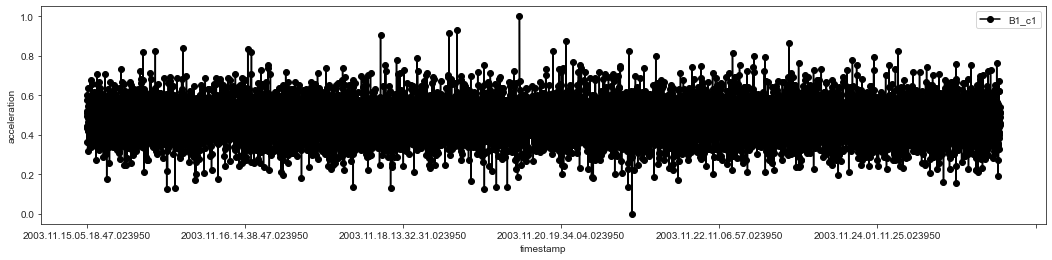

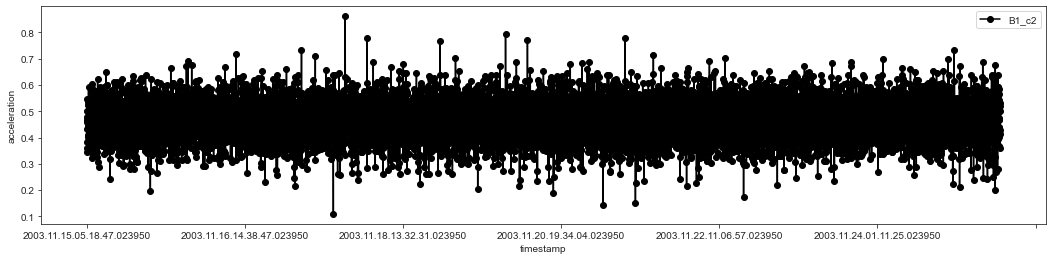

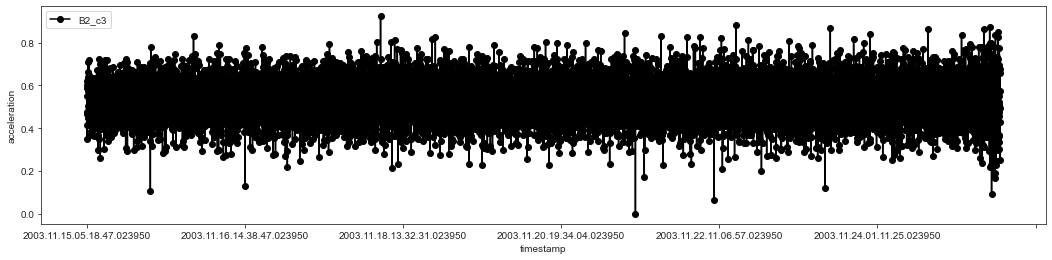

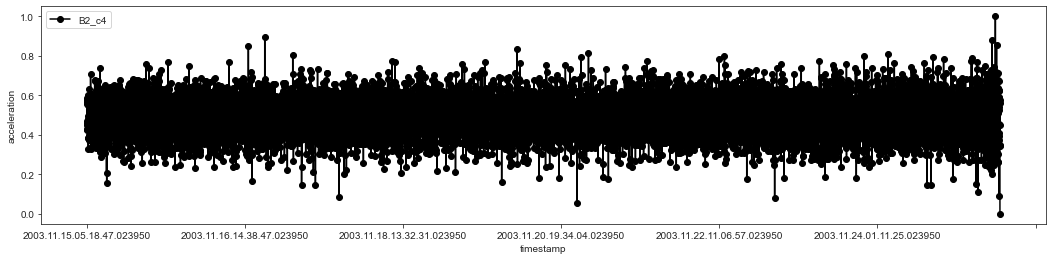

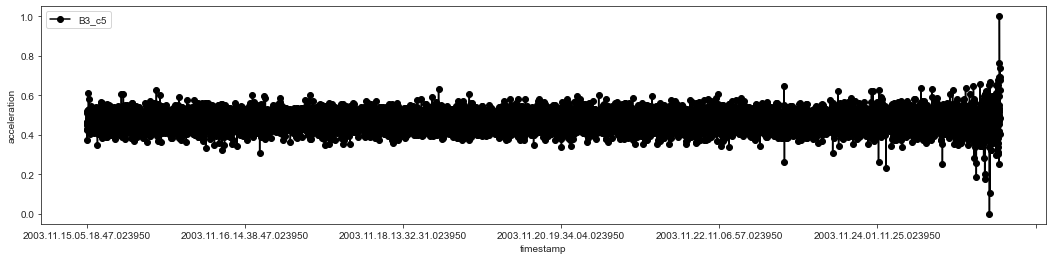

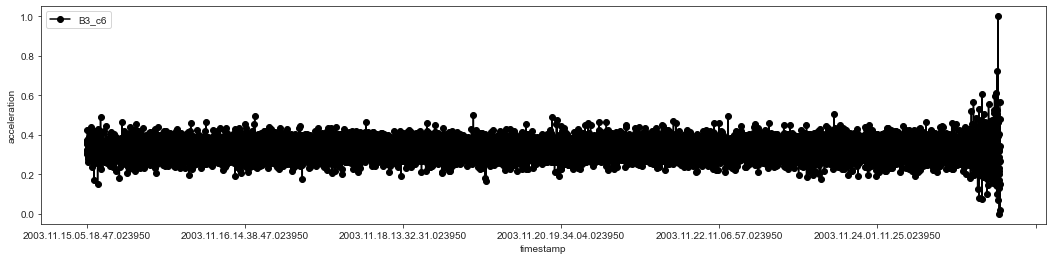

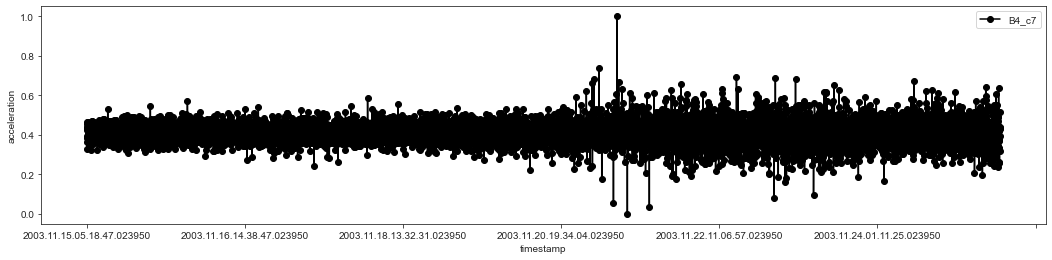

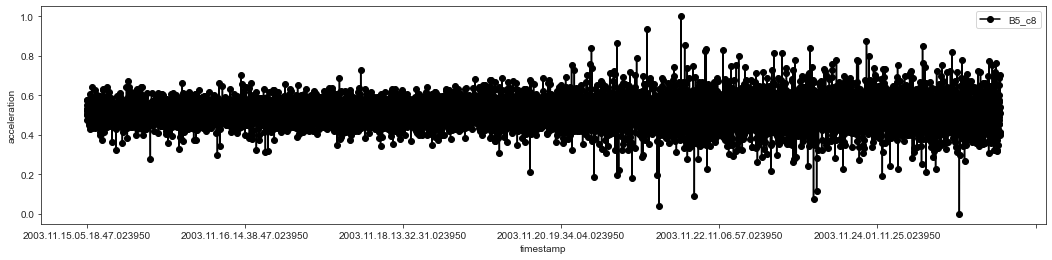

In [23]:
# Plot the downsampled test signals
for chan in cols:
    df_test[[chan]].plot(figsize=(18, 4), color = 'black', marker = 'o')     
    plt.ylabel("acceleration")

### MODEL 1. Principal Components analysis (PCA)

In [24]:
cut_date = '2003.11.15.05.18.47.023950'
df_train = df_scaled.loc[df_scaled.index <= cut_date]
df_test = df_scaled.loc[df_scaled.index > cut_date]

# Define the PCA model (all compoments)
n_comps = len(chans) # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test_PCA = pca.transform(df_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = df_test.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.326 0.207 0.184 0.113 0.057 0.044 0.039 0.029]


In [25]:
# Redefine the PCA model (selecting eigenvectors with highest eigenvalues)
n_comps = 5 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test_PCA = pca.transform(df_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = df_test.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.326 0.207 0.184 0.113 0.057]


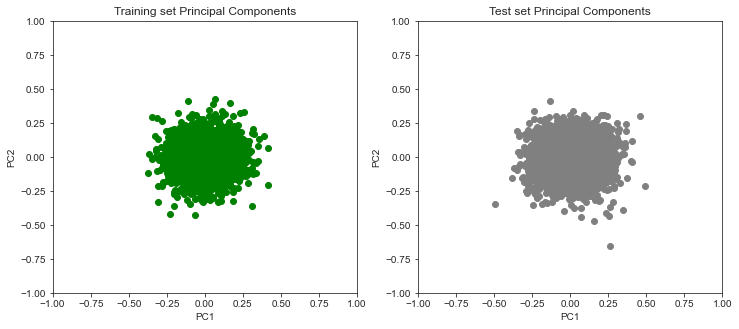

In [26]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-1, 1)
ax0.set_ylim(-1, 1)
ax0.set_title('Training set Principal Components')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test_PCA.loc[:, 0], X_test_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_title('Test set Principal Components')

plt.show()

In [27]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [28]:
#cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [29]:
cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

In [30]:
# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

Mean distr [-1.757e-17 -1.162e-17  7.911e-17  3.798e-17 -5.019e-17]


In [31]:
# Mahalanobis Distance calculation
dist_test = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MhD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MhD in test set    :", min(dist_test), max(dist_test))

Minimum & maximum MhD in training set: 0.29046119976721696 8.732361299338693
Minimum & maximum MhD in test set    : 0.3196223906791421 11.970339816244872


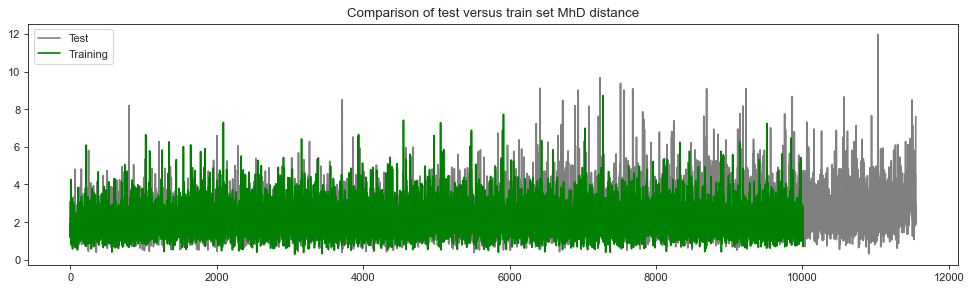

In [32]:
figure(figsize = (15, 4), dpi = 80)
plt.plot(np.array(dist_test), label = "Test", color = 'grey')
plt.plot(np.array(dist_train) , label = "Training", color = 'green')
plt.legend(loc = "upper left")
plt.title("Comparison of test versus train set MhD distance")
plt.show()

In [33]:
threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold) )

Threshold value for flagging an anomaly is 6.25


/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


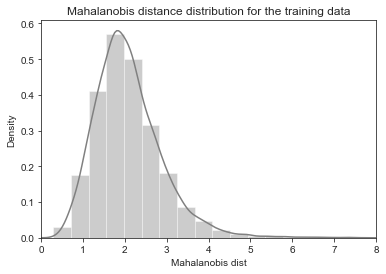

In [34]:
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde= True, 
            color = 'grey');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [35]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

n_outliers_train = anomaly_train[ anomaly_train['Anomaly'] == True].shape[0]
print("There are", n_outliers_train, "anomalies in the train set out of", anomaly_train.shape[0], "points")
print("Corresponding to " + str(round(100*(n_outliers_train / anomaly_train.shape[0]), 2)) + '%')

There are 18 anomalies in the train set out of 10010 points
Corresponding to 0.18%


In [36]:
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index

n_outliers = anomaly[anomaly['Anomaly'] == True].shape[0]
print("There are", n_outliers, "anomalies in the test set out of", anomaly.shape[0], "points")
print("Corresponding to " + str(round(100*(n_outliers / anomaly.shape[0]), 2)) + '%')

There are 65 anomalies in the test set out of 11550 points
Corresponding to 0.56%


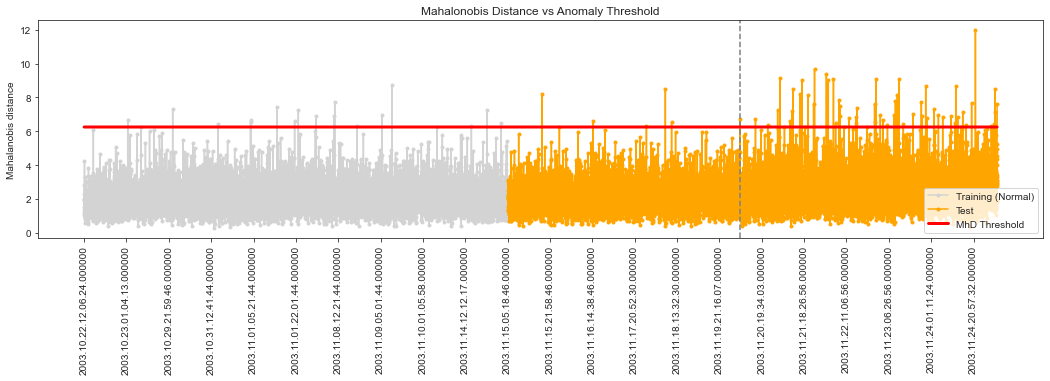

In [37]:
# Prepare the data for plotting to inspect performance further
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index

anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_train['timestamp'] = anomaly_train.index
anomaly['timestamp'] = anomaly.index
anomaly_alldata['timestamp'] = anomaly_alldata.index

fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Training (Normal)')        
ax.plot(anomaly['timestamp'], anomaly['Mob dist'], color = 'orange', marker = '.', zorder = 2, label = f'Test')
ax.plot(anomaly_alldata['timestamp'], anomaly_alldata['Thresh'], color = 'red', marker = None, zorder = 3, linewidth = 3, label = 'MhD Threshold')
plt.xticks(np.arange(0, anomaly_alldata.shape[0], 1000), fontsize=10, rotation = 90)
plt.axvline(x=estimated_degrading_startend_ind , color='grey', linestyle='dashed')  
plt.ylabel("Mahalanobis distance")
plt.title('Mahalonobis Distance vs Anomaly Threshold')
ax.legend(loc = 'lower right')
plt.show()

From the plot above we can see that the frequency of threshold breach starts to increase significantly from about 2003-11-20.  The magnitude of the breach also increases significantly.  We can conclude that the model is is predicting the degrading state of the bearing configuration well.  The false positive rate during normal operating conditions is also relatively low at 0.2%.

### MODEL 2. Clustering & Euclidean Distance
Try a K-means clustering approach where we group together usual combinations of features. The points that are far from the cluster are points with an unusual combination of features and these points will be classified as anomalies.

In [38]:
from sklearn.cluster import KMeans

In [39]:
# Standardize the features
scaler1 = preprocessing.StandardScaler()
np_scaled = scaler1.fit_transform(df_set)
data = pd.DataFrame(np_scaled)

# Reduce to 2 PCA features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# Standardize these 2 new features
scaler2 = preprocessing.StandardScaler()
np_scaled = scaler2.fit_transform(data)
data = pd.DataFrame(np_scaled, columns = ['PC1', 'PC2'])

# Evaluate effect of using robust PCA 
# Robust PCA
#L, S = pdm.R_pca(df_set.drop(['status', 'timestamp'], axis = 1)).fit()
#scaler3 = preprocessing.StandardScaler()
#np_scaled = scaler3.fit_transform(L)
#data = pd.DataFrame(np_scaled)

# Reduce to 2 PCA features
#rpca = PCA(n_components=2)
#data = rpca.fit_transform(data)

# Standardize these 2 new features
#scaler4 = preprocessing.StandardScaler()
#np_scaled = scaler4.fit_transform(data)
#data = pd.DataFrame(np_scaled)

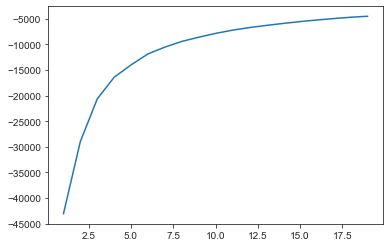

In [40]:
# Calculate with different numbers of centroids & plot the loss (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i, random_state=1234).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [41]:
# Choose 15 centroids & add these data to the base dataframe
#kmeans_model = KMeans(n_clusters=15, random_state=1234).fit(data)
if 'df' in globals(): del df
df = df_set.copy(deep=True)
df['cluster'] = kmeans[14].predict(data)
df.reset_index(drop = True, inplace = True)
df['principal_feature1'] = pd.Series(data['PC1'])
df['principal_feature2'] = pd.Series(data['PC2'])
df['cluster'].value_counts()

4     2739
11    2275
12    2178
5     2092
6     2000
9     1800
0     1738
1     1307
13    1090
14    1040
2     1037
10     708
8      610
7      564
3      382
Name: cluster, dtype: int64

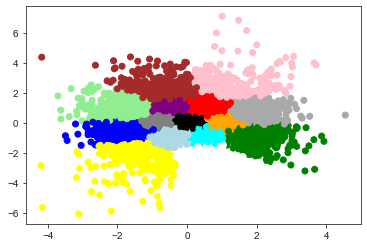

In [42]:
# Plot the different clusters with the 2x PCA component features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [43]:
# Create a dataframe of cluster centroid coordinates
x_coords = []
y_coords = []
for p in range(15):
    x_coords.append(kmeans[14].cluster_centers_[p][0])
    y_coords.append(kmeans[14].cluster_centers_[p][1])    
    
coords_cl = pd.DataFrame({
    'cluster':range(0, 15, 1),
    'x_coords':pd.Series(x_coords),
    'y_coords':pd.Series(y_coords),
})

In [44]:
# Create a dataframe of PCs, cluster, status, etc. and join with the coords
backdrop_chan = 'B3_c6'
examine_cl = pd.DataFrame({        
    backdrop_chan:pd.Series(df[backdrop_chan]),
    'PC1':pd.Series(df.principal_feature1),
    'PC2':pd.Series(df.principal_feature2),
    'cluster':pd.Series(df.cluster)
})
examine_cl = pd.merge(examine_cl, coords_cl, how='left', on='cluster')

In [64]:
"""
Create a list of distances between each point & its distance to cluster centroid
Use Euclidean distance 
d = √((x_2-x_1)²+(y_2-y_1)²) 
"""
calc_dists = []
for d in range(len(examine_cl)):
    x1 = examine_cl.PC1.iloc[d]
    x2 = examine_cl.x_coords.iloc[d]
    y1 = examine_cl.PC2.iloc[d]
    y2 = examine_cl.y_coords.iloc[d]
    calc_dists.append(np.sqrt(np.square(x2-x1) + np.square(y2-y1)))

In [65]:
# Assign an oultlier fraction & calculate prediction based on threshold
outliers_fraction = 0.005
examine_cl = examine_cl.assign(distance = calc_dists)
number_of_outliers = int(outliers_fraction * len(examine_cl))
calc_threshold = examine_cl.distance.nlargest(number_of_outliers).min()
print(f'Distance threshold is {round(calc_threshold, 3)}')
examine_cl = examine_cl.assign(threshold = calc_threshold)
examine_cl = examine_cl.assign(prediction = (examine_cl.distance > examine_cl.threshold).astype(int))

Distance threshold is 1.742


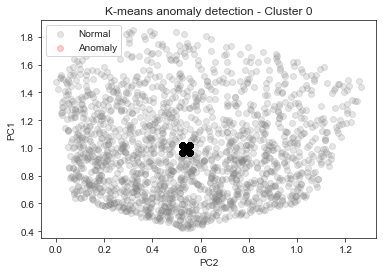

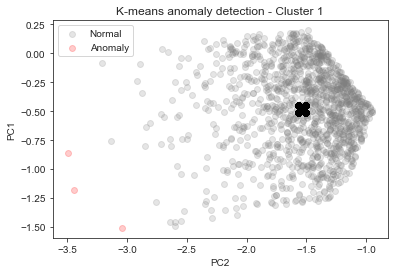

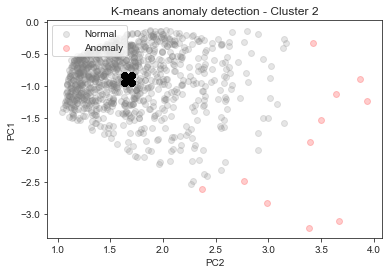

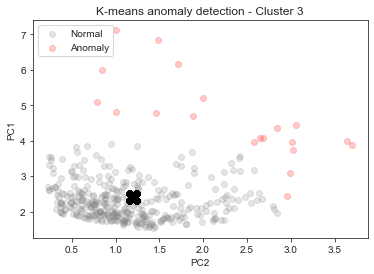

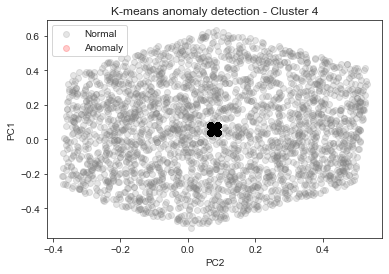

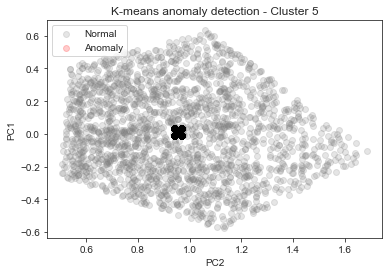

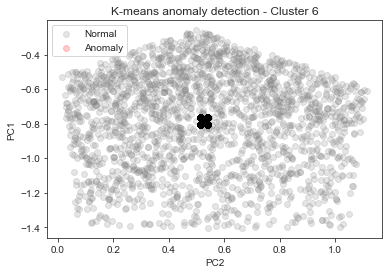

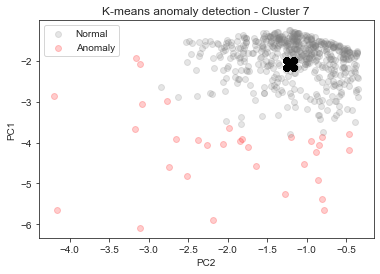

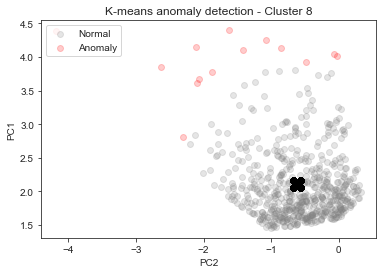

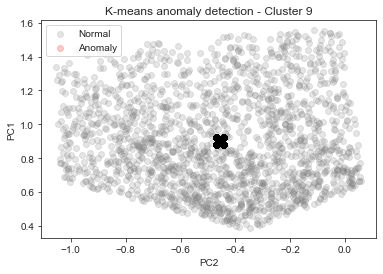

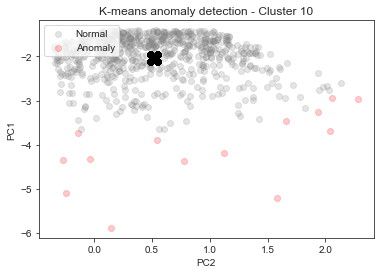

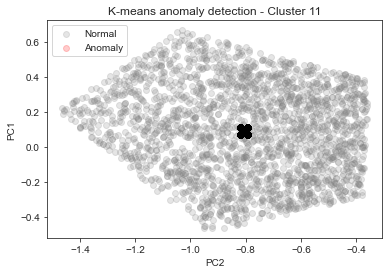

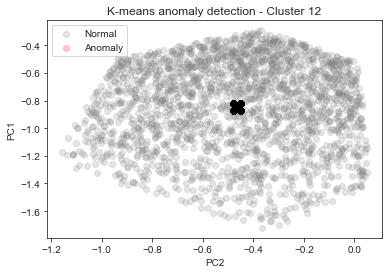

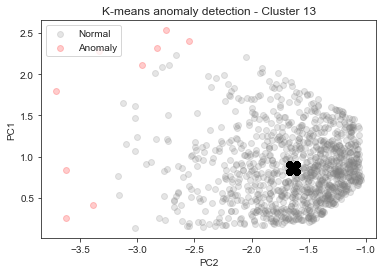

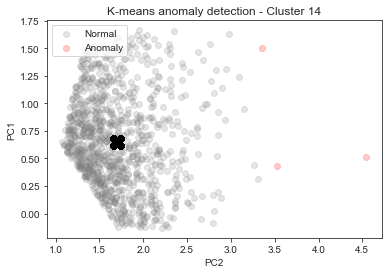

In [66]:
# Plot each cluster
for cl in range(15):    
    tmp_0 = examine_cl[(examine_cl.prediction == 0) & (examine_cl.cluster == cl)]
    tmp_1 = examine_cl[(examine_cl.prediction == 1) & (examine_cl.cluster == cl)]
    # Visualisation of anomaly with cluster view
    fig, ax = plt.subplots()

    # Now plot
    ax.scatter(tmp_0.PC1, tmp_0.PC2, zorder = 2, alpha = 0.2, c = 'grey', label = 'Normal')
    ax.scatter(tmp_1.PC1, tmp_1.PC2, zorder = 1, alpha = 0.2, c = 'red', label = 'Anomaly')
    ax.scatter(tmp_0.x_coords, tmp_0.y_coords, zorder = 3, marker = 'X', s = 200, alpha = 0.1, c = 'black')
    ax.scatter(tmp_1.x_coords, tmp_1.y_coords, zorder = 3, marker = 'X', s = 200, alpha = 0.1, c = 'black')
    plt.ylabel("PC1")
    plt.xlabel("PC2")
    plt.title(f'K-means anomaly detection - Cluster {cl}')
    ax.legend(loc = 'upper left') 
    plt.show()

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


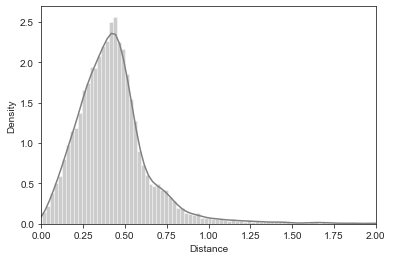

In [67]:
# Plot distribution of distances
plt.figure()
sns.distplot(examine_cl.distance, bins = 200, kde = True, color = 'grey');
plt.xlim([0.0, 2])
plt.xlabel('Distance')
plt.show()

In [68]:
print(f'Selected anomaly percentage: {100 * outliers_fraction}%')
print('Selected threshold distance:', round(examine_cl.threshold.unique()[0], 3))

Selected anomaly percentage: 0.5%
Selected threshold distance: 1.742


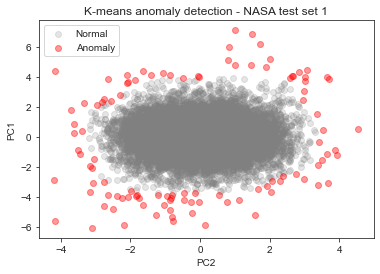

In [83]:
# Visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize = (6, 4))

# Now plot
ax.scatter(examine_cl[examine_cl.prediction == 0].PC1, examine_cl[examine_cl.prediction == 0].PC2, 
           zorder = 1, alpha = 0.2, c = 'grey', label = 'Normal')
ax.scatter(examine_cl[examine_cl.prediction == 1].PC1, examine_cl[examine_cl.prediction == 1].PC2, 
           zorder = 2, alpha = 0.4, c = 'red', label = 'Anomaly')
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.title('K-means anomaly detection - NASA test set 1')
ax.legend(loc = 'upper left')  
plt.show()

In [71]:
examine_cl.index = df_set.index

In [72]:
res_snap_cl = examine_cl.loc[examine_cl.index.isin(df_train.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
cl_to = len(res_snap_cl['prediction'])
cl_fp = sum(res_snap_cl['prediction'] == 1)
cl_tn = sum(res_snap_cl['prediction'] == 0)
print(f'False positives is {cl_fp} ({round(100*cl_fp/cl_to, 2)}%)')
print(f'Check {"{:,}".format(cl_to)} (total rows) = {"{:,}".format(cl_fp+cl_tn)} (FP + TN count): {cl_to == (cl_fp+cl_tn)}')

False positives is 19 (0.19%)
Check 10,010 (total rows) = 10,010 (FP + TN count): True


In [73]:
res_snap_cl = examine_cl.loc[examine_cl.index.isin(df_test.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
cl_to = len(res_snap_cl['prediction'])
cl_an = sum(res_snap_cl['prediction'] == 1)
cl_nn = sum(res_snap_cl['prediction'] == 0)
print(f'Anomaly point count is {cl_an} ({round(100*cl_an/cl_to, 2)}%)')
print(f'Check {"{:,}".format(cl_to)} (total rows) = {"{:,}".format(cl_an+cl_nn)} (FP + TN count): {cl_to == (cl_an+cl_nn)}')

Anomaly point count is 87 (0.75%)
Check 11,550 (total rows) = 11,550 (FP + TN count): True


#### Visualise Results

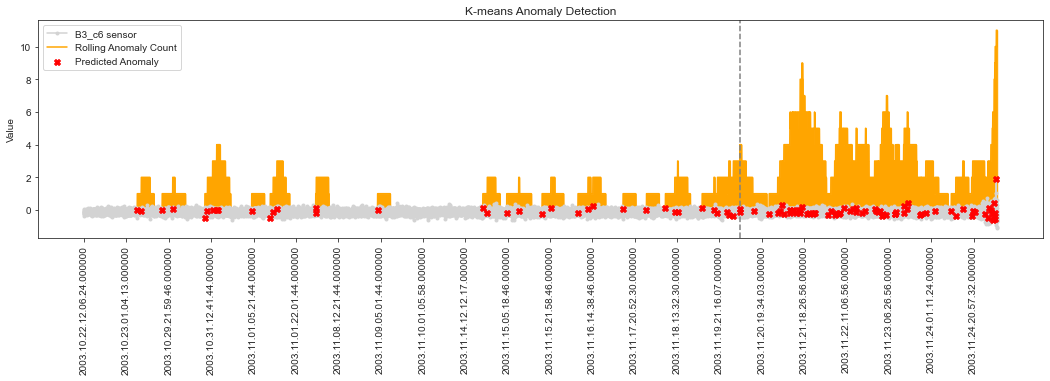

In [84]:
# Create visualisation of anomaly detection through time
fig, ax = plt.subplots(figsize = (18, 4))

# Create a subset dataset of anomalies
a = examine_cl.loc[examine_cl['prediction'] == 1, ['B3_c6']] # anomaly using sensor as backdrop

# Create a rolling count of anomalies
# window = 300 corresponds to approximately 300 x 0.1 = 30 seconds
roll_anom = examine_cl.rolling(300, min_periods=1, closed='right').sum()

ax.plot(examine_cl.index, df['B3_c6'], color='lightgrey', marker = '.', zorder=2, label = 'B3_c6 sensor')
ax.plot(roll_anom.index, roll_anom['prediction'], color='orange', zorder=1, label = 'Rolling Anomaly Count')
ax.scatter(a.index, a['B3_c6'], color='red', marker='X', zorder=4, label = 'Predicted Anomaly')
ax.fill_between(roll_anom.index, 0, roll_anom['prediction'], color='orange', zorder=1)
plt.xticks(np.arange(0, anomaly_alldata.shape[0], 1000), fontsize=10, rotation = 90)
plt.axvline(x=estimated_degrading_startend_ind , color='grey', linestyle='dashed')  
plt.ylabel("Value")
plt.title('K-means Anomaly Detection')
ax.legend(loc = 'upper left')  
plt.show()

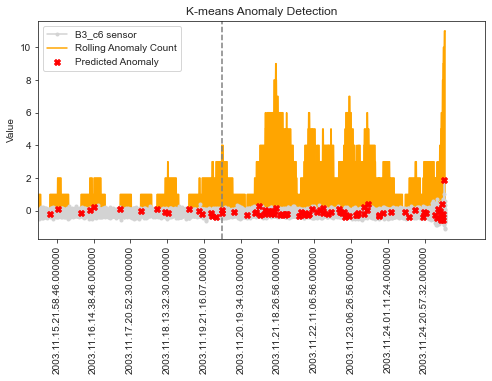

In [92]:
# Create visualisation of anomaly detection through time
fig, ax = plt.subplots(figsize = (8, 4))

ax.plot(examine_cl.index, df['B3_c6'], color='lightgrey', marker = '.', zorder=2, label = 'B3_c6 sensor')
ax.plot(roll_anom.index, roll_anom['prediction'], color='orange', zorder=1, label = 'Rolling Anomaly Count')
ax.scatter(a.index, a['B3_c6'], color='red', marker='X', zorder=4, label = 'Predicted Anomaly')
ax.fill_between(roll_anom.index, 0, roll_anom['prediction'], color='orange', zorder=1)
plt.xticks(np.arange(0, anomaly_alldata.shape[0], 1000), fontsize=10, rotation = 90)
plt.axvline(x=estimated_degrading_startend_ind , color='grey', linestyle='dashed')  
plt.ylabel("Value")
ax.set_xlim(10500)
plt.title('K-means Anomaly Detection')
ax.legend(loc = 'upper left')  
plt.show()

The above plot shows anomaly distribution over time using channel B3_c6 as a backdrop.  While anomalies are present for the duration of the time series, the frequency of occurence ncreases from 2003-11-20. A simple rolling window count of anomalies is plotted in orange area fill.  This identifies a noticable shift in the rolling anomaly count around the time when it is suspected that bearings started to degrade (refer to b5_c8 time history).  There is also a notably splike at the end when failure ocurred.   

### MODEL 3. One-class Support Vector Machine (SVM)

SVMs use hyperplanes in multi-dimensional space to separate one class of observations from another. In a one-class SVM problem, all data belongs to a single class (often the normal class). The model is trained to learn these 'normal' conditions, so that when a new data is encountered, it can identify whether it should belong to trained class or not. If not, the new data is labeled as an anomaly.

In [94]:
from sklearn.svm import OneClassSVM

In [95]:
cut_date = '2003.11.15.05.18.47.023950'
df_train = df_scaled.loc[df_scaled.index <= cut_date]
df_test = df_scaled.loc[df_scaled.index > cut_date]

In [96]:
# Train a one-class SVM 
svm_model =  OneClassSVM(nu = 0.005) # 0.5%
svm_model.fit(pd.DataFrame(df_train))

OneClassSVM(nu=0.005)

In [97]:
print('Train: ', [df_train.index[0], df_train.index[-1]])
print('Test:', [df_test.index[0], df_test.index[-1]])

Train:  ['2003.10.22.12.06.24.000000', '2003.11.15.05.18.47.023950']
Test: ['2003.11.15.05.28.46.000000', '2003.11.25.23.39.57.023950']


In [98]:
# Select a channel to use as a backdrop when plotting anomalies over time
backdrop_chan = 'B5_c8'
preds_svm = pd.Series(svm_model.predict(df_scaled)).map({1: 0, -1: 1})
preds_svm = pd.DataFrame({'prediction':preds_svm})
preds_svm.index = df_scaled.index
preds_svm[backdrop_chan] = df_scaled[backdrop_chan]

In [99]:
res_snap_svm = preds_svm.loc[preds_svm.index.isin(df_train.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
svm_to = len(res_snap_svm['prediction'])
svm_fp = sum(res_snap_svm['prediction'] == 1)
svm_tn = sum(res_snap_svm['prediction'] == 0)
print(f'False positives is {svm_fp} ({round(100*svm_fp/svm_to, 2)}%)')
print(f'Check {"{:,}".format(svm_to)} (total rows) = {"{:,}".format(svm_fp+svm_tn)} (FP + TN count): {svm_to == (svm_fp+svm_tn)}')

False positives is 58 (0.58%)
Check 10,010 (total rows) = 10,010 (FP + TN count): True


In [100]:
res_snap_svm = preds_svm.loc[preds_svm.index.isin(df_test.index),:]
svm_to = len(res_snap_svm['prediction'])
svm_an = sum(res_snap_svm['prediction'] == 1)
svm_nn = sum(res_snap_svm['prediction'] == 0)
print(f'Anomaly point count is {svm_an} ({round(100*svm_an/svm_to, 2)}%)')
print(f'Check {"{:,}".format(svm_to)} (total rows) = {"{:,}".format(svm_an+svm_nn)} (FP + TN count): {svm_to == (svm_an+svm_nn)}')

Anomaly point count is 437 (3.78%)
Check 11,550 (total rows) = 11,550 (FP + TN count): True


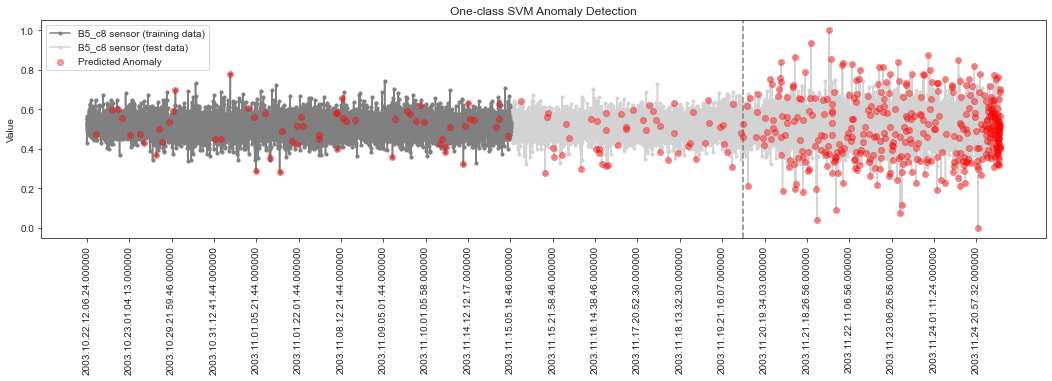

In [101]:
# Create visualisation of anomaly detection through time
fig, ax = plt.subplots(figsize = (18, 4))

# Create a subset dataset of anomalies
a = preds_svm.loc[preds_svm['prediction'] == 1, [backdrop_chan]] # anomaly using sensor as backdrop

ax.plot(df_train.index, df_train[backdrop_chan], color='grey', marker = '.', zorder=2, label = f'{backdrop_chan} sensor (training data)')
ax.plot(df_scaled.index, df_scaled[backdrop_chan], color='lightgrey', marker = '.', zorder=1, label = f'{backdrop_chan} sensor (test data)')
ax.scatter(a.index, a[backdrop_chan], facecolors='r', edgecolors='r', marker='o', alpha=0.4, zorder=3, label = 'Predicted Anomaly')
plt.xticks(np.arange(0, df_scaled.shape[0], 1000), fontsize=10, rotation = 90)
plt.title('One-class SVM Anomaly Detection')
plt.axvline(x=estimated_degrading_startend_ind , color='grey', linestyle='dashed')  
plt.ylabel("Value")
ax.legend(loc = 'upper left')  
plt.show()

The above plot shows anomaly distribution over time using channel B5_c8 as a backdrop.  While anomalies are present for the duration of the time series, the frequency of occurence significantly increases from c.2003-11-20. This is around the time when it is suspected that the bearings actually started to degrade (from inspection of the b5_c8 time history).  

### MODEL 4. Isolation Forest

An Isolation Forest is a tree-based unsupervised model.  In an Isolation Forest, randomly sub-sampled data are processed in a tree structure based on randomly selected features. Samples that travel deeper into the tree are less likely to be anomalies as they required more cuts to isolate them. Similarly, the samples which end up in shorter branches indicate anomalies as it was easier for the tree to separate them from other observations.

In [102]:
from sklearn.ensemble import IsolationForest

In [103]:
cut_date = '2003.11.15.05.18.47.023950'
df_train = df_scaled.loc[df_scaled.index <= cut_date]
df_test = df_scaled.loc[df_scaled.index > cut_date]

In [104]:
# Train isolation forest 
isfo_model =  IsolationForest(contamination = 0.005) #0.5%
isfo_model.fit(df_train)

IsolationForest(contamination=0.005)

In [105]:
# Select a channel to use as a backdrop when plotting anomalies over time
backdrop_chan = 'B5_c8'
preds_isfo = pd.Series(isfo_model.predict(df_scaled)).map({1: 0, -1: 1})
preds_isfo = pd.DataFrame({'prediction':preds_isfo})
preds_isfo.index = df_scaled.index
preds_isfo[backdrop_chan] = df_scaled[backdrop_chan]

In [106]:
res_snap_isfo = preds_isfo.loc[preds_isfo.index.isin(df_train.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
isfo_to = len(res_snap_isfo['prediction'])
isfo_fp = sum(res_snap_isfo['prediction'] == 1)
isfo_tn = sum(res_snap_isfo['prediction'] == 0)
print(f'False positives is {isfo_fp} ({round(100*isfo_fp/isfo_to, 2)}%)')
print(f'Check {"{:,}".format(isfo_to)} (total rows) = {"{:,}".format(isfo_fp+isfo_tn)} (FP + TN count): {isfo_to == (isfo_fp+isfo_tn)}')

False positives is 51 (0.51%)
Check 10,010 (total rows) = 10,010 (FP + TN count): True


In [107]:
res_snap_isfo = preds_isfo.loc[preds_isfo.index.isin(df_test.index),:]
isfo_to = len(res_snap_isfo['prediction'])
isfo_an = sum(res_snap_isfo['prediction'] == 1)
isfo_nn = sum(res_snap_isfo['prediction'] == 0)
print(f'Anomaly point count is {isfo_an} ({round(100*isfo_an/isfo_to, 2)}%)')
print(f'Check {"{:,}".format(isfo_to)} (total rows) = {"{:,}".format(isfo_an+isfo_nn)} (FP + TN count): {isfo_to == (isfo_an+isfo_nn)}')

Anomaly point count is 202 (1.75%)
Check 11,550 (total rows) = 11,550 (FP + TN count): True


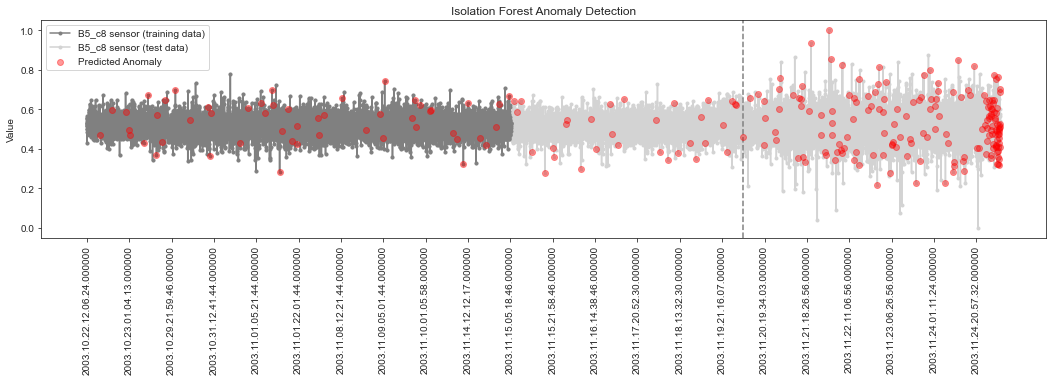

In [108]:
# Create visualisation of anomaly detection through time
fig, ax = plt.subplots(figsize = (18, 4))

# Create a subset dataset of anomalies
b = preds_isfo.loc[preds_isfo['prediction'] == 1, [backdrop_chan]] # anomaly using sensor as backdrop

ax.plot(df_train.index, df_train[backdrop_chan], color='grey', marker = '.', zorder=2, label = f'{backdrop_chan} sensor (training data)')
ax.plot(df_scaled.index, df_scaled[backdrop_chan], color='lightgrey', marker = '.', zorder=1, label = f'{backdrop_chan} sensor (test data)')
ax.scatter(b.index, b[backdrop_chan], facecolors='r', edgecolors='r', marker='o', alpha=0.4, zorder=3, label = 'Predicted Anomaly')
plt.xticks(np.arange(0, df_scaled.shape[0], 1000), fontsize=10, rotation = 90)
plt.title('Isolation Forest Anomaly Detection')
plt.axvline(x=estimated_degrading_startend_ind , color='grey', linestyle='dashed')  
plt.ylabel("Value")
ax.legend(loc = 'upper left')  
plt.show()

The above plot shows anomaly distribution over time using channel B5_c8 as a backdrop.  While anomalies are present for the duration of the time series, the frequency of occurence starts to increase from c.2003-11-20. Again, this is around the time when it is suspected that the bearings actually started to degrade (from inspection of the b5_c8 time history).  The identification of degradation is more subtle than the step change obsvered with the SVM model.  The model also identifies the actual end of test (and failure) quite well with a noticable increase in denisty at this time (right hand edge of the above plot). 

### MODEL 5. Autoencoder LSTM

An autoencoder is a type of ANN that is used to learn efficient codings of unlabeled data (i.e., unsupervised learning).  In this autoencoder model, Long Short-Term Memory (LSTM) neural network cells are used. LSTM networks are a sub-type of the more general recurrent neural networks (RNN). A key attribute of recurrent neural networks is their ability to persist information, or cell state, for use later in the network. This makes them particularly well suited for analysis of time series data.  The rationale for using this architecture for anomaly detection is that we train the model on 'normal' data and determine the resutling reconstruction error.  Then, when the model encounters data that is outside the norm and attempts to reconstruct it, we will see an increase in the reconstruction error (as the model was never trained to accurately recreate data from outside the norm.

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import keras

In [ ]:
# Set random seed
seed(13)
tf.random.set_seed(13)

In [ ]:
cut_date = '2003.11.15.05.18.47.023950'
df_train = df_scaled.loc[df_scaled.index <= cut_date]
df_train_arr = df_train.to_numpy()
df_test = df_scaled.loc[df_scaled.index > cut_date]
df_test_arr = df_test.to_numpy()

In [ ]:
# Reshape inputs for LSTM [samples, timesteps, features]
X_train = df_train_arr.reshape(df_train_arr.shape[0], 1, df_train_arr.shape[1])
print("Training data shape:", X_train.shape)

X_test = df_test_arr.reshape(df_test_arr.shape[0], 1, df_test_arr.shape[1])
print("Test data shape:", X_test.shape)

In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(24, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(24, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# Create the autoencoder model
model = autoencoder_model(X_train)
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mae')
model.summary()

In [ ]:
# Fit the model to the data
"""
# Some notes on hyperparameters:
# ==============================
# Batch Size: Hyperparameter of gradient descent that controls the no. of 
# training samples to work through before the model’s internal parameters are updated.
- Batch Gradient Descent: Batch Size = Size of Training Set
- Stochastic Gradient Descent: Batch Size = 1
- Mini-Batch Gradient Descent: 1 < Batch Size < Size of Training Set

In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples.

Epochs: Hyperparameter of gradient descent that controls the number of complete 
passes through the training dataset
"""
nb_epochs = 100
batch_size = 128
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.10).history

In [ ]:
# Plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'grey', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
# Plot the loss distribution of the training set
sns.set_style('ticks') #whitegrid
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train.index

scored = pd.DataFrame(index=df_train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(8, 4), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'black');
plt.xlim([0.0, 0.5])

In [ ]:
def calc_test_loss(test, test_df, thresh):
    # Calculate the loss on the test set
    X_pred = model.predict(test)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=test_df.columns)
    X_pred.index = test_df.index

    scored = pd.DataFrame(index=test_df.index)
    Xtest = test.reshape(test.shape[0], test.shape[2])
    scored['loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis=1)
    scored['threshold'] = thresh
    scored['prediction'] = (scored['loss_mae'] > scored['threshold']).astype(int)
    scored[backdrop_chan] = test_df[backdrop_chan]
    print(scored.head())
    return(scored)

In [ ]:
# Calculate the loss on the test set 1
selected_threshold = 0.10
preds_lstma = calc_test_loss(X_test, df_test, selected_threshold)

In [ ]:
# Calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train.columns)
X_pred_train.index = df_train.index

scored_train = pd.DataFrame(index=df_train.index)
scored_train['loss_mae'] = np.mean(np.abs(X_pred_train - Xtrain), axis = 1)
scored_train['threshold'] = selected_threshold
scored_train['prediction'] = (scored_train['loss_mae'] > scored_train['threshold']).astype(int)
scored_train[backdrop_chan] = df_train[backdrop_chan]

preds_lstma = pd.concat([scored_train, preds_lstma])
preds_lstma['timestamp'] = preds_lstma.index
#preds_lstma

In [ ]:
res_snap_lstma = preds_lstma.loc[preds_lstma.index.isin(df_train.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
lstma_to = len(res_snap_lstma['prediction'])
lstma_fp = sum(res_snap_lstma['prediction'] == 1)
lstma_tn = sum(res_snap_lstma['prediction'] == 0)
print(f'False positives is {lstma_fp} ({round(100*lstma_fp/lstma_to, 2)}%)')
print(f'Check {"{:,}".format(lstma_to)} (total rows) = {"{:,}".format(lstma_fp+lstma_tn)} (FP + TN count): {lstma_to == (lstma_fp+lstma_tn)}')

In [ ]:
res_snap_lstma = preds_lstma.loc[preds_lstma.index.isin(df_test.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
lstma_to = len(res_snap_lstma['prediction'])
lstma_tp = sum(res_snap_lstma['prediction'] == 1)
print(f'Anomaly count in test zone is {lstma_tp} ({round(100*lstma_tp/lstma_to, 2)}%)')

In [ ]:
# Create a subset dataset of anomalies
b = preds_lstma.loc[preds_lstma['prediction'] == 1, ['timestamp', 'threshold', 'loss_mae', backdrop_chan]] #

In [ ]:
# Create visualisation of loss vs threshold through time
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(preds_lstma['loss_mae'], color='grey', marker = '.', zorder=1, label = 'Loss MAE')
ax.plot(preds_lstma['threshold'], color='red', marker = None, linewidth=3, zorder=2, label = 'MAE Threshold')
ax.scatter(b['timestamp'], b['loss_mae'], facecolors='r', edgecolors='r', marker='o', alpha=0.8, zorder=3, label = 'Predicted Anomaly')
plt.xticks(np.arange(0, df_scaled.shape[0], 1000), fontsize=10, rotation = 90)
plt.title('LSTM Autoencoder Anomaly Detection - Loss MAE vs Threshold')
ax.legend(loc = 'upper left')  
plt.show()

In [ ]:
preds_lstma

In [ ]:
# Create visualisation of anomaly detection through time
roll_anom = preds_lstma.prediction.rolling(300, min_periods=1, closed='right').sum()

In [ ]:
# Create visualisation of anomaly detection through time
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_train.index, df_train[backdrop_chan], color='grey', marker = '.', zorder=2, label = f'{backdrop_chan} sensor (training data)')
ax.plot(df_scaled.index, df_scaled[backdrop_chan], color='lightgrey', marker = '.', zorder=1, label = f'{backdrop_chan} sensor (test data)')
ax.scatter(b.index, b[backdrop_chan], facecolors='r', edgecolors='r', marker='o', alpha=0.8, zorder=3, label = 'Predicted Anomaly')
plt.xticks(np.arange(0, df_scaled.shape[0], 1000), fontsize=10, rotation = 90)
plt.title('LSTM Autoencoder Anomaly Detection - Predicted Anomaly Distribution')
plt.axvline(x=estimated_degrading_startend_ind , color='grey', linestyle='dashed')  
plt.ylabel("Value")
ax.legend(loc = 'upper left')  
plt.show()

While there is a change in anomaly frequency after the dashed vertical 'degradation' line in the above plot, it does apepar to be quite faint.  There is however a notbal blob of anomalies at the end (bearing failure).  Take a look at a rolling count of anomalies and visualize to better see shift from normal to degrading.  

In [ ]:
# Create visualisation of anomaly detection through time
roll_anom = preds_lstma.prediction.rolling(300, min_periods=1, closed='right').sum()

fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(roll_anom.index, roll_anom, color='orange', zorder=1, label = 'Rolling Anomaly Count')
ax.scatter(b.index, b[backdrop_chan], facecolors='r', edgecolors='r', marker='o', alpha=0.8, zorder=3, label = 'Predicted Anomaly')
ax.fill_between(roll_anom.index, 0, roll_anom, color='orange', zorder=1)
plt.xticks(np.arange(0, df_scaled.shape[0], 1000), fontsize=10, rotation = 90)
plt.title('LSTM Autoencoder Anomaly Detection - Predicted Anomaly Distribution with Rolling Count')
plt.axvline(x=estimated_degrading_startend_ind , color='grey', linestyle='dashed')  
plt.ylabel("Value")
ax.legend(loc = 'upper left')  
plt.show()

Still quite faint, but there is an obvious difference in anomaly detection to the left and right of the degradation line.